In [5]:
import numpy as np

from scipy.special import gammaln, gamma
from scipy.linalg import cholesky, solve_triangular

import matplotlib.pyplot as plt

from multivariate_util import multivariate_t_rvs

In [2]:
def compute_mahalanobis(X, mu, prc_chol):
    y = np.dot(X, prc_chol) - np.dot(mu, prc_chol)
    return np.sum(np.square(y), axis=1).reshape(-1, 1)

In [34]:
def compute_prec_chol(cov):
    _, p = np.array(cov).shape
    cov_chol = cholesky(cov, lower=True)
    return solve_triangular(cov_chol, np.eye(p), lower=True).T

In [35]:
def mgamma(u, a, b):
    return b ** a * u ** (a-1) * np.exp(-.5 * df * u) / gamma(a)

In [36]:
def normal(X, u, mu, cov):
    n, p = X.shape
    
    cov_chol = cholesky(cov, lower=True)
    prc_chol = solve_triangular(cov_chol, np.eye(p), lower=True).T
    
    top    = np.exp(-.5 * u * compute_mahalanobis(X, mu, prc_chol))
    bottom = (2 * np.pi) ** (p*.5) * np.linalg.det(cov) ** .5
    
    return top/bottom

In [37]:
def log_likelihood(X, u, mu, cov, df):
    n, p = X.shape
    log  = lambda x : np.log(x)
    det  = lambda x : np.linalg.det(x)
    
    prc_chol = compute_prec_chol(cov)
    log_det  = log(prc_chol.reshape(1, -1)[:,::p+1]).sum()
    
#     return .5*(-p*log(2*np.pi) - log(det(cov)) - u*compute_mahalanobis(X, mu, prc_chol) \
#               + df*log(df*.5) + df*(log(u) - u)) - gammaln(df*.5) - log(u)
    return .5*(-p*log(2*np.pi) - u*compute_mahalanobis(X, mu, prc_chol) \
              + df*log(df*.5) + df*(log(u) - u)) - gammaln(df*.5) - log(u) \
              + log_det

# Generating sample

[[ -9.58839298e-04   2.25365302e-01]
 [  3.63438406e-01   3.24664403e-01]
 [ -7.51929858e-01   2.31857726e-01]
 [ -8.08353353e-01   1.58723453e+00]
 [  5.37897620e-01   9.26903864e-01]]


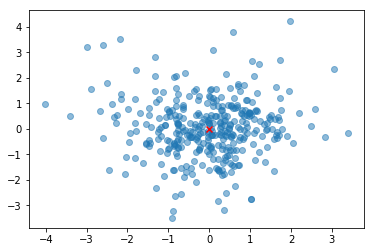

In [38]:
np.random.seed(0)

mu  = [0,0]
cov = [[1,0], [0,1]]
df  = 7.5

X = multivariate_t_rvs(mu, cov, df, 350)
print X[:5]

plt.scatter(X.T[0], X.T[1], alpha=.5)
plt.scatter(mu[0], mu[1], c='r', marker='x')
plt.show()

# EM

In [39]:
def random_choice(X):
    idx = np.random.choice(range(len(X)))
    return X[idx]

In [43]:
def compute_u(X, mu, cov, df):
    _, p = X.shape
    prc_chol = compute_prec_chol(cov)
    return (df + p)/(df + compute_mahalanobis(X, mu, prc_chol))

In [125]:
# guessing mu and sigma
mu  = random_choice(X)
cov = np.cov(X.T)

In [126]:
# computing u
u = compute_u(X, mu, cov, df)

In [128]:
# EM
_, p = X.shape

bottom = -np.inf
l = []
for _ in range(100):
    prev = bottom
    
    mu  = (X * u).sum(0) / u.sum()
    cov = np.dot(u.T * X.T, X) / len(X)

    u = compute_u(X, mu, cov, df)
    
    bottom = log_likelihood(X, u, mu, cov, df).sum()
    l.append(bottom)
    if abs(bottom - prev) < 1e-10:
        print 'converged within {} iterations'.format(_)
        print 'mu'; print mu
        print '\ncov'; print cov
        
        break

converged within 1 iterations
mu
[-0.01206931  0.0099787 ]

cov
[[ 0.93448624  0.0277795 ]
 [ 0.0277795   0.9730121 ]]


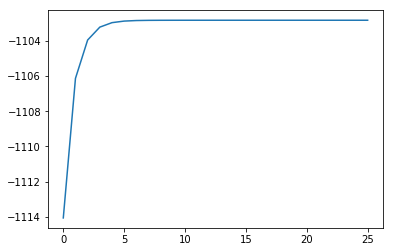

In [112]:
arr = range(len(l))
plt.plot(arr, l)
plt.show()

In [113]:
xmin, xmax = min(X.T[0]), max(X.T[0])
ymin, ymax = min(X.T[1]), max(X.T[1])
xx, yy = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]

xy = np.c_[(xx.ravel(), yy.ravel())]

In [114]:
def t_dist(X, mu, cov, df):
    _, p = X.shape
    v_p  = df + p
    
    prc_chol = compute_prec_chol(cov)
    
    top = gamma(v_p *.5) * np.linalg.det(cov)**-1
    bottom = (np.pi * df) ** (p*.5) * gamma(df*.5) * (1 + compute_mahalanobis(X, mu, prc_chol)/df) ** (v_p*.5)
    
    return top/bottom

In [115]:
zz = t_dist(xy, mu, cov, df)

In [116]:
Z = np.reshape(zz, xx.shape)

In [117]:
from scipy.stats import chi2

In [118]:
threshold = chi2.ppf(.975, 2) ** .5

In [119]:
prc_chol = compute_prec_chol(cov)
outlier = compute_mahalanobis(X, mu, prc_chol)**.5 > threshold

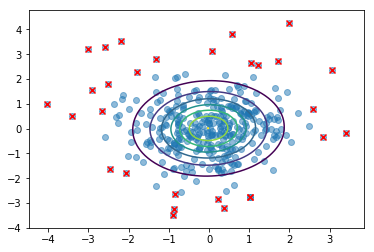

In [120]:
plt.scatter(X.T[0], X.T[1], alpha=.5)
plt.scatter(X[outlier.ravel(),:].T[0], X[outlier.ravel(),:].T[1], c='r', marker='x')

plt.contour(xx, yy, Z)

plt.show()